In [29]:
%%capture --no-display
%pip install ipympl mplcursors seaborn openpyxl
%matplotlib widget
import matplotlib as mpl


font = {
    'family': 'serif',
    'color':  '#02082e',
    'weight': 'normal',
    'size': 12,
}
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.family'] = 'serif'


import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
plt.ion()

import seaborn as sns
import numpy as np

In [2]:
%%capture --no-display
%pip install logkicker
from compactblocks.stats import received_stats, sent_stats, sent_window_stats, sent_already_over_stats

# Summary

I connected two Bitcoin Core nodes running on mainnet, one prefilling transactions to a node that only received `CMPCTBLOCK` announcements from its prefilling peer. Even though the intended effects of prefilling transactions are network-wide, and it would be nice to have some more complicated topologies and scenarios tested in e.g. [Warnet](https://github.com/bitcoin-dev-project/warnet), this basic setup can be used to validate some of the basic assumptions of the effects of prefilling:
1. Does prefilling work to prevent failed block reconstructions that otherwise require `GETBLOCKTXN->BLOCKTXN` roundtrips, irrespective of the cost of prefilling?
2. Does prefilling result in a net reduction on block propagation times?

The results indicate that the answer to 1. is definitively yes. The metric used by [0xB10C/2025-03-prefill-compactblocks](https://github.com/0xB10C/bitcoin/commits/2025-03-prefill-compactblocks/) of prefilling the transactions we were missing from our mempool when performing block reconstruction resulted in an observed reconstruction rate of 98.25% for a node receiving prefilled CMPCTBLOCK announcements when both the prefilling node and the prefill-receiving node are running similar builds of Bitcoin Core, compared to the observed reconstruction rate on a node not receiving prefilled blocks of of 61.81%. Some of those prefills, as pointed out by @Crypt-iQ and @gmaxwell  above, exceeded the TCP window, and likely resulted in an additional round-trip, negating the benefit of prefilling. But, in my measurements, 85.78% of the prefills would have fit in the partially occupied TCP window a prefilling node sent the `CMPCTBLOCK`'s in. Projecting out, these measurements indicate that if all Bitcoin Core nodes had been prefilling during the period which I measured data, the reconstruction rate would have been  and we can likely do better taking advantage of the fact, pointed out by @andrewtoth [above](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052/25) that similar peers will likely have similar `vExtraTxn`.

I think the following improvements should be made to [0xB10C/2025-03-prefill-compactblocks](https://github.com/0xB10C/bitcoin/commits/2025-03-prefill-compactblocks/):

##### Definitely:
- Only prefill up to the next TCP window boundary.
- Always insert candidates from `vExtraTxn` last.

##### Maybe:
- Within DoS limits (maybe a limit of 4 MiB per valid header), temporarily store a per-block cache of prefilled transactions you hear about, increasing the chances that you successfully reconstruct without having to wait for an RTT.
- If the send window can't fit all of the prefill candidates, prefill a random selection of candidates, always prefilling transactions not in `vExtraTxn` first.

Future investigations should:
1. Use prefill-receiving nodes to measure the amount of duplicate / redundant data in the prefill.
2. Use two peers with stable and high (maybe artificial?) latencies to easily estimate the number of round-trips that messages take to pass between them, there is also probably external tooling that can measure this.
3. Measure / reason about effects of prefilling at a distance of more than one hop.
4. Measure data about the `GETBLOCKTXN` messages that a prefilling node receives from random peers. 

# Latency and Bandwidth

**Feel free to skip the math in this section or to [skip](#Observations) reading this section entirely.**

Taking a simplified view, the latency for a receiver to hear an unsolicited message (the scenario we care about in block relay) consists of
transmission delay plus propagation delay: 
$$
\text{Latency} \approx \frac{\text{Data}}{\text{Bandwidth}} + \sim{\frac{1}{2}} * \text{Round-trip time}
$$

Any time compact block reconstruction fails because the receiver was missing transactions, an additional round-trip-time (RTT) of requesting missing transactions and receiving them (`GETBLOCKTXN->BLOCKTXN`) must be paid in order to complete reconstruction, but at this point the amount of data that needs to be transmitted for reconstruction to succeed does not change. Where $f$ is the probability for a block to fail reconstruction:

$$
\text{Latency} \approx \frac{\text{Data}}{\text{Bandwidth}} + \sim{\frac{1}{2}}\text{RTT} + f * \text{RTT}
$$

If we had perfect information about the transactions our peer will be missing, we should always send these along with the block announcements since we will pay basically the same transmission delay, minus the unnecessary round-trip. If we don't have perfect information, then the worst we can do is send transactions which our peer already knew about, while not sending them transactions they didn't know about, incurring the RTT anyways, plus the transmission time of the redundant data. Let's say we send $p$ extra prefill bytes, with each byte having a probability $n$ of being redundant and prefilling $p$ bytes gets us a reconstruction failure probability of $f_{p}$, then:

$$
\text{Latency}_\text{Prefilling} \approx \frac{\text{Data}}{\text{Bandwidth}} + \frac{p * n}{\text{Bandwidth}} + \sim{\frac{1}{2}}\text{RTT} + f_p * \text{RTT}
$$

## Criterion for deciding if prefilling is advantageous

In order for prefilling latency to be better than or equal to no-prefilling latency, the following inequality must be satisfied:

$$
\frac{p * n}{\text{Bandwidth}*\text{RTT}} \leq f_0 - f_p
$$

<details>
<summary> 
    
#### Derivation
</summary>

If latency while prefilling is less than or equal to latency without prefilling, where $b$ is bandwidth, $r$ is the RTT, $d$ is the size of the CMPCTBLOCK without prefill, $p$ is the size of the prefill, and $f_p$ is the reconstruction failure rate at a given prefill size $p$:

$$
\frac{d}{b} + \frac{pn}{b} + \frac{1}{2}r + {f_p}{r} \leq \frac{d}{b} + \frac{1}{2}r + {f_0}{r}
$$

Subtracting the common terms $\frac{d}{b}$ and $\frac{1}{2}r$ from both sides:

$$
\frac{pn}{b} + {f_p}{r} \leq {f_0}{r}
$$

Subtracting ${f_p}{r}$ from both sides:

$$
\frac{pn}{b} \leq {f_0}{r} - {f_p}{r}
$$

Dividing both sides by $r$:

$$
\frac{pn}{{b} {r}} \leq {f_0} - {f_p}
$$

</details>


If we plug in some example values, prefilling 10KiB with a bandwidth of 5 MiB/s and an RTT of 50ms (.050s) and use a worst case $n$ of 1

$$
\frac{10\text{KiB}*1}{5 \text{MiB/s} * 0.050\text{s}} = 0.0488
$$

In this case, if prefilling improves reconstruction rates by at least 4.9% it is definitely better than not prefilling.

## Latency Cost of Prefilling

And we can quantify the latency cost of prefilling over not prefilling as:

$$
\text{Latency}_\text{Prefilling} - \text{Latency}_\text{Not prefilling} = \frac{p*n}{\text{Bandwidth}} - r(f_0 - f_p)
$$

## TCP windows and the costs of prefilling.

But, the use of TCP in the Bitcoin P2P protocol complicates this, because a sender will not send data exceeding the TCP window size in a single round-trip. Instead, they will send up to the window size in data, wait for an `ACK` from the receiver, and then send up to `window` bytes after the data which was `ACK`ed. That means that if we exceed a single TCP window, we will have to pay an additional RTT in propagation latency (and a little bit of transmission latency for the overhead). And for each additional window we overflow, we will pay another RTT:

$$
\text{TCP Latency} \approx \frac{\text{Data}}{\text{Bandwidth}} + \sim{\frac{1}{2}}\text{RTT} + f * \text{RTT} + \lfloor{\frac{\text{Data}}{\text{Window Size}}}\rfloor\text{RTT}
$$

Note $\lfloor a \rfloor$ meaning `std::floor(a)`

Doing a similar dance as above, where $p$ is the prefill size and $f_p$ is the probability of reconstruction failure at prefill size $p$, and $n$ is the probability of a prefill byte being redundant:

$$
\frac{p*n}{\text{Bandwidth}*\text{RTT}} \leq f_0 - f_p + \lfloor{\frac{\text{Data}}{\text{Window Size}}}\rfloor - \lfloor{\frac{\text{Data}+p}{\text{Window Size}}}\rfloor
$$

The "TCP window" is the smaller of two values: the receiver advertised window (`rwnd`) and the sender-calculated congestion window (`cwnd`).

### Overflowing current TCP window is always worse than doing nothing

The above formula establishes as a rule something which might have been intuited, that if the prefill causes us to exceed the current TCP window, then we will always do worse than if we hadn't prefilled, since:
1. $f_0 - f_p \leq 1$ since the smallest number $f_0$ can be is 0, and the largest number $f_p$ can be is 1.
2. $\lfloor{\frac{\text{Data}}{\text{Window Size}}}\rfloor - \lfloor{\frac{\text{Data}+p}{\text{Window Size}}}\rfloor \leq -1$ if the prefill overflows the current partially filled TCP window.
3. If $a \leq 1$ and $b \leq -1$, then $a + b \leq 0$, so the right hand side of the formula is $\leq 0$.
4. The left hand side of the equation will always be $\geq 0$, since none of the variables on the left side can ever be negative.
5. If $lhs \geq 0$ and $0 \geq rhs$, then $lhs \geq rhs$, so the left hand side will never be less than the right hand side, therefore prefilling will never be beneficial.

But, if we bound our prefill $p$ so that we never increase the number of TCP windows used, i.e.: $\lfloor{\frac{\text{Data}}{\text{Window Size}}}\rfloor - \lfloor{\frac{\text{Data}+p}{\text{Window Size}}}\rfloor = 0$ which, I believe is [easy](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052/29) to do, we can use the exact same formula as above to decide whether or not prefilling is effective:

$$
\frac{p * n}{\text{Bandwidth}*\text{RTT}} \leq f_0 - f_p
$$

### Complication: TCP Retransmission

So far, I have assumed perfectly reliable networks and this isn't always the case, packets get lost, and in TCP that means waiting for a timeout, and then retransmitting. But, I believe the problem above I've described in relation to prefilling is very similar to the problem that the designers of TCP had in selecting a static window size, and later, dynamic window sizes through congestion control algorithms like those described in [RFC 5681](https://datatracker.ietf.org/doc/html/rfc5681) and [RFC 9438](https://datatracker.ietf.org/doc/html/rfc9438). Instead of the probability that a block reconstruction will fail, they deal with the probability that a packet will not arrive, in both cases, the consequence is an additional round-trip, and a core question is whether the marginal value of potentially saving a round-trip by packing in more data is worth the risk that retransmission will be necessary anyways. The analogy is imperfect, as there are many more concerns that TCP congestion control algorithms deal with, but I argue that the node can outsource the question: "How large of a message can we send and reasonably expect everything to arrive?" to its operating system's congestion control implementation.

### Complication: Cost of Bandwidth

In all of the above, I have assumed the cost of using bandwidth is 0 outside of the latency cost. I've done this because I believe the cost of the redundant transactions sent in compact block prefills is negligible, the data I measured below suggests that prefills will be on the order of ~20KiB, so worst case monthly bandwidth usage of prefilling, assuming every byte is redundant and did not need to be sent, and that you always receive a prefilled CMPCTBLOCK from three HB peers, is ~300 MiB. (3 HB Peers * 20 KiB * 6 * 24 * 31)

## Takeaways
I don't think proving that the above inequality being satisfied is necessary for a prefilling solution, what I think it's useful for is building an intuition of the problem, and setting theoretical boundaries on how effective prefilling needs to be to be worth it.
- Nodes are likelier to suffer rather than benefit from prefilling that have smaller $Bandwidth * RTT$ (See [Bandwidth-delay product (BDP)](https://en.wikipedia.org/wiki/Bandwidth-delay_product)) connections: e.g. nodes with low bandwidth and low ping. And nodes that have connections with large BDP's are likelier to benefit, e.g. high-bandwidth, high-latency connections("Long Fat Networks" as described in [RFC 7323](https://datatracker.ietf.org/doc/html/rfc7323#section-1.1))
- If the redundant broadcast probability $n$ is zero, prefilling is always worth it.

# Observation Setup

I connected a prefilling node to a prefill-receiving node, both nodes had additional logging added to measure things like TCP window sizes. The data used was recorded over over 20 days, since that is how long it took for `debug.log` with `-debug=net` to fill up the prefilling node's disk.

## Prefilling node
I ran one node with 0xB10C's prefilling branch([0xB10C/2025-03-prefill-compactblocks](https://github.com/0xB10C/bitcoin/commits/2025-03-prefill-compactblocks/)) with some additional logging ([davidgumberg/06-18-2025-0xB10C-prefill-branch-with-logging](https://github.com/davidgumberg/bitcoin/commits/06-18-2025-0xB10C-prefill-branch-with-logging/))

In summary, the prefilling node, during compact block reconstruction, [identifies as prefill candidates](https://github.com/0xB10C/bitcoin/commit/b381c1ed035f1f8cbc1a41fe383b8329e948a775) transactions that were in the block and not in its mempool. When sending CMPCTBLOCK's, it [passes the prefill candidates](https://github.com/0xB10C/bitcoin/commit/fd07f0164683572e0eeed1787711831859ef0fab) in the `PrefilledTransaction` structure of the `CMPCTBLOCK` announcement, [described](https://github.com/bitcoin/bips/blob/master/bip-0152.mediawiki#prefilledtransaction) in [BIP-0152](https://github.com/bitcoin/bips/blob/master/bip-0152.mediawiki). This is in contrast to the present use of the `CMPCTBLOCK` prefill in Bitcoin Core, which is [only used](https://github.com/bitcoin/bitcoin/blob/b53fab1467fde73c40402e2022b25edfff1e4668/src/blockencodings.cpp#L25) to prefill coinbase transactions.

## Prefill-receiving node
I ran another node on a branch which will only ask for and listen to `CMPCTBLOCK` announcements from manually added peers (https://github.com/davidgumberg/bitcoin/commits/5-20-25-cmpct-manual-only/). I made a manual connection from this node to the prefilling node, this node doesn't do any prefilling, but like every Bitcoin Core node today, it will parse and use `PrefilledTransaction`'s that it receives. No changes are required for nodes to enjoy the benefits/drawbacks of prefilling that their peers do, but I modified this node in order to measure the effects of receiving prefilled blocks in isolation.

## Config

Both nodes had identical `bitcoin.conf`'s aside from the `addnode=<ip-of-prefilling-node>` configuration in the prefill-receiving node.

```
prune=1000
debug=bench
debug=cmpctblock
debug=net
dbcache=1000
logtimemicros=1
```

In [3]:
# Load prefillee node data into Dataframes

# sadly this must be done here to make jupyter lite happy.
import pandas as pd
pd.options.mode.copy_on_write = True 

prefillreceiverxlsx = "prefillreceiver.xlsx"
# Each xlsx file contains two datasheets, one with data about received blocks and one with data about sent blocks
prefillreceiver_received = pd.read_excel(prefillreceiverxlsx, sheet_name='received')
prefillreceiver_sent = pd.read_excel(prefillreceiverxlsx, sheet_name='sent')

In [4]:
# Load prefilling node data into Dataframes


prefillerxlsx = "prefiller.xlsx"
# Each xlsx file contains two datasheets, one with data about received blocks and one with data about sent blocks
prefiller_received = pd.read_excel(prefillerxlsx, sheet_name='received')
prefiller_sent = pd.read_excel(prefillerxlsx, sheet_name='sent')

# Data

The data was all taken from `debug.log`'s generated by the nodes and parsed with this python script: https://github.com/davidgumberg/logkicker/blob/main/compactblocks/logsparser.py

- Statistics: https://github.com/davidgumberg/logkicker/blob/main/compactblocks/stats.py
- Plots: https://github.com/davidgumberg/logkicker/blob/main/compactblocks/plots.py

## Receiving Node
This data was gathered from a node configured so that it would only receive CMPCTBLOCK announcements from our prefilling node, the main thing to see here is that reconstruction generally succeeds, the average reconstruction time metric is misleading, since we don't count extra RTT's that happen in the TCP layer in reconstruction time, just the time we receive the `CMPCTBLOCK` until the time we have reconstructed it.


In [30]:
def received_stats(received: pd.DataFrame) -> None:
    total_cb_received = len(received)
    if total_cb_received == 0:
        return
    failed_blocks = received[received['received_tx_missing'] > 0]
    fail_rate = len(failed_blocks) / total_cb_received
    print(f"{len(failed_blocks)} out of {total_cb_received} blocks received failed reconstruction. ({fail_rate * 100:.2f}%)")
    reco_rate = 1 - fail_rate
    print(f"Reconstruction rate was {reco_rate * 100:.2f}%")

    avg_received_size = received['received_size'].mean()
    print(f"Avg size of received block: {avg_received_size:.2f} bytes")

    avg_missing_tx_size = received['bytes_missing'].mean()
    print(f"Avg bytes missing from received blocks: {avg_missing_tx_size:.2f} bytes")

    avg_missing_from_failed = failed_blocks['bytes_missing'].mean()
    print(f"Avg bytes missing from blocks that failed reconstruction: {avg_missing_from_failed:.2f} bytes")

    avg_reco_time = (received['time_reconstructed'] - received['time_received']).mean()
    avg_reco_time_in_ms = avg_reco_time.value / (1000 * 1000)
    print(f"Avg reconstruction time: {avg_reco_time_in_ms}ms")
    
received_stats(prefillreceiver_received)

49 out of 2793 blocks received failed reconstruction. (1.75%)
Reconstruction rate was 98.25%
Avg size of received block: 55851.93 bytes
Avg bytes missing from received blocks: 603.40 bytes
Avg bytes missing from blocks that failed reconstruction: 34393.55 bytes
Avg reconstruction time: 7.821697ms


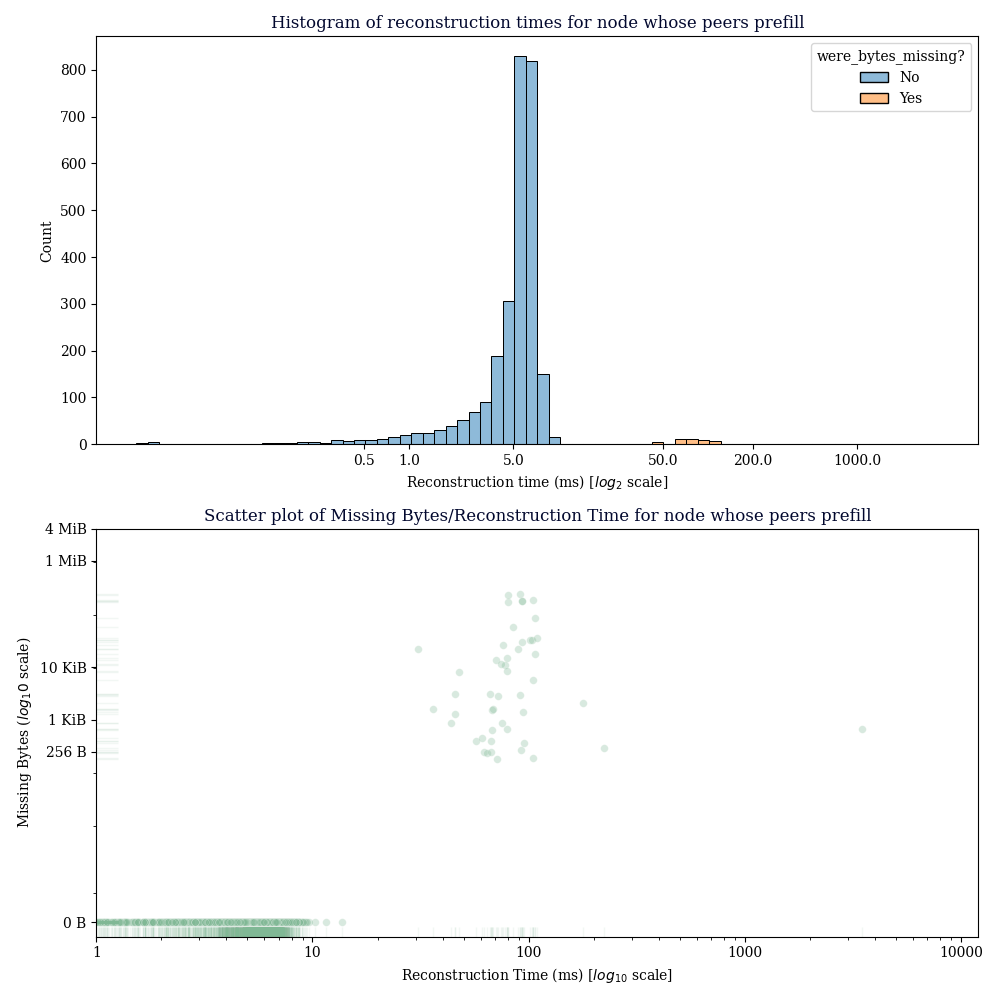

In [24]:
# Plot reconstruction time histogram and bytesmissing/reconstructiontime scatterplot

def plot_reconstruction_histogram_and_scatterplot(received, title): 
    histcolor = "#749940"
    received['reconstruction_time_ms'] = received['reconstruction_time_ns'] / 1_000_000
    received['were_bytes_missing?'] = np.where(received['bytes_missing'] > 0, 'Yes', 'No')

    f, [ax1, ax2] = plt.subplots(2, figsize=(10,10), tight_layout=True)
    # Histplot on top
    sns.histplot(data=received, x='reconstruction_time_ms', hue='were_bytes_missing?', ax=ax1, color=histcolor, log_scale=2, bins=70)
    ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax1.set_xticks([0.5, 1, 5, 50, 200, 1000])
    ax1.set_title(f'Histogram of reconstruction times for {title}', fontdict=font)
    ax1.xaxis.set_label_text('Reconstruction time (ms) [$log_{2}$ scale]')

    # Scatterplot on bottom "
    scattercolor = "#80b895"
    xticks = [1, 10, 50, 100, 1000]
    yticks_bytes = [0, 256, 1024, 10*1024, 1024*1024, 4*1024*1024] # 256B, 1KB, 10KB, 100KB, 1MB, 4MB
    ytick_labels = ['0 B', '256 B', '1 KiB', '10 KiB', '1 MiB', '4 MiB']
    sns.scatterplot(data=received, x='reconstruction_time_ms', y='bytes_missing', 
                    ax=ax2, color=scattercolor, alpha=0.3, s=30)
    sns.rugplot(data=received, x='reconstruction_time_ms', y='bytes_missing', 
                    ax=ax2, color=scattercolor, alpha=0.1)

    ax2.set_title(f'Scatter plot of Missing Bytes/Reconstruction Time for {title}',fontdict=font)
    ax2.set_xlabel('Reconstruction Time (ms) [$log_{10}$ scale]')
    ax2.set_xticks(xticks)
    ax2.set_xscale('log') 
    ax2.set_xlim(left=1)
    ax2.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

    ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax2.set_ylim(-0.5)
    ax2.set_ylabel('Missing Bytes ($log_10$ scale)')
    ax2.set_yscale('symlog') 
    ax2.set_yticks(yticks_bytes)
    ax2.set_yticklabels(ytick_labels)

plot_reconstruction_histogram_and_scatterplot(prefillreceiver_received, 'a node whose peers prefill')

## Prefilling Node
This data was gathered from the node that sends prefilled compact blocks to its peers. Because this node is otherwise unmodified, we can use its measurements on the receiving side as a baseline for block reconstruction on nodes today.

In [7]:
def received_stats(received: pd.DataFrame) -> None:
    total_cb_received = len(received)
    if total_cb_received == 0:
        return
    failed_blocks = received[received['received_tx_missing'] > 0]
    fail_rate = len(failed_blocks) / total_cb_received
    print(f"{len(failed_blocks)} out of {total_cb_received} blocks received failed reconstruction. ({fail_rate * 100:.2f}%)")
    reco_rate = 1 - fail_rate
    print(f"Reconstruction rate was {reco_rate * 100:.2f}%")

    avg_received_size = received['received_size'].mean()
    print(f"Avg size of received block: {avg_received_size:.2f} bytes")

    avg_missing_tx_size = received['bytes_missing'].mean()
    print(f"Avg bytes missing from received blocks: {avg_missing_tx_size:.2f} bytes")

    avg_missing_from_failed = failed_blocks['bytes_missing'].mean()
    print(f"Avg bytes missing from blocks that failed reconstruction: {avg_missing_from_failed:.2f} bytes")

    avg_reco_time = (received['time_reconstructed'] - received['time_received']).mean()
    avg_reco_time_in_ms = avg_reco_time.value / (1000 * 1000)
    print(f"Avg reconstruction time: {avg_reco_time_in_ms}ms")

received_stats(prefiller_received)

1101 out of 2883 blocks received failed reconstruction. (38.19%)
Reconstruction rate was 61.81%
Avg size of received block: 15957.20 bytes
Avg bytes missing from received blocks: 47849.36 bytes
Avg bytes missing from blocks that failed reconstruction: 125294.91 bytes
Avg reconstruction time: 25.741588ms


### Distribution of Received Compact Block Sizes

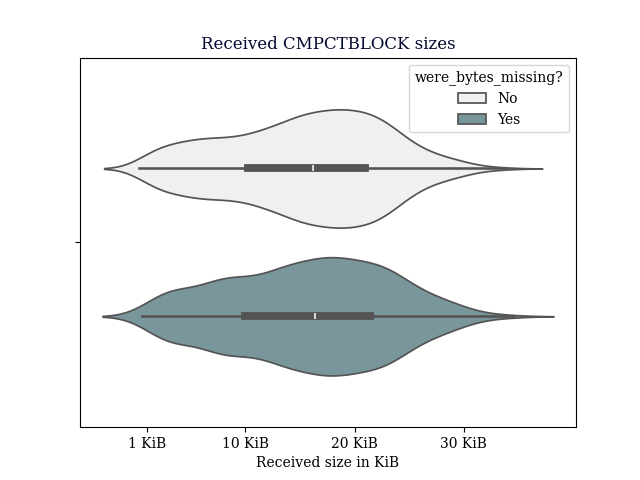

In [21]:
# Make violinplot of received CMPCTBLOCK's.
def plot_received_size(prefiller_received):
    prefiller_received['were_bytes_missing?'] = np.where(prefiller_received['bytes_missing'] > 0, 'Yes', 'No')
    histcolor = "#749993"
    f, ax1 = plt.subplots()

    sns.violinplot(data=prefiller_received, x='received_size', hue='were_bytes_missing?', palette='light:#7499a3',
        ax=ax1, gap=0.2)
    xticks_bytes = [1024, 10*1024, 20*1024, 30*1024]
    xtick_labels = ['1 KiB', '10 KiB', '20 KiB', '30 KiB']
    ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax1.set_xticks(xticks_bytes)
    ax1.set_xticklabels(xtick_labels)

    ax1.set_title('Received CMPCTBLOCK sizes',  fontdict=font)
    ax1.xaxis.set_label_text('Received size in KiB')

plot_received_size(prefiller_received)

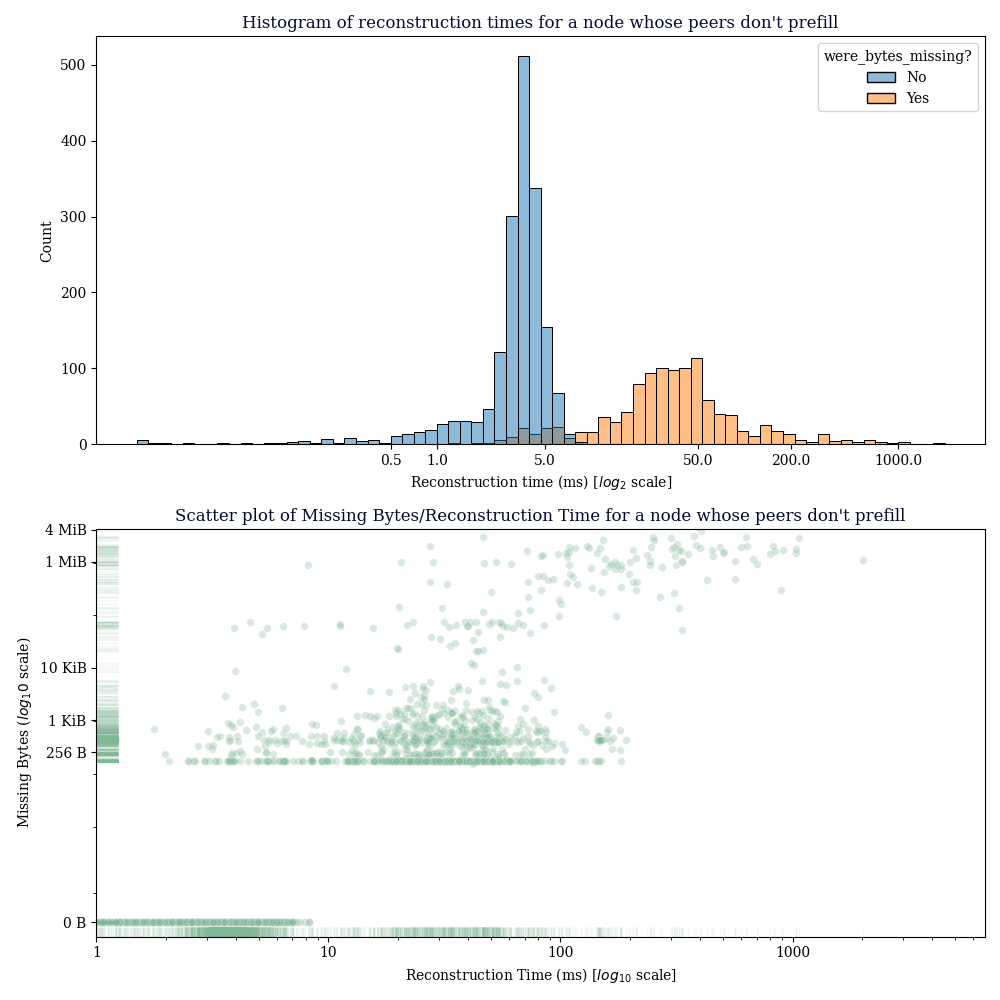

In [25]:
# Plot reconstruction time histogram and bytesmissing/reconstructiontime scatterplot
def plot_reconstruction_histogram_and_scatterplot(received, title): 
    histcolor = "#749940"
    received['reconstruction_time_ms'] = received['reconstruction_time_ns'] / 1_000_000
    received['were_bytes_missing?'] = np.where(received['bytes_missing'] > 0, 'Yes', 'No')

    f, [ax1, ax2] = plt.subplots(2, figsize=(10,10), tight_layout=True)
    # Histplot on top
    sns.histplot(data=received, x='reconstruction_time_ms', hue='were_bytes_missing?', ax=ax1, color=histcolor, log_scale=2, bins=70)
    ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax1.set_xticks([0.5, 1, 5, 50, 200, 1000])
    ax1.set_title(f'Histogram of reconstruction times for {title}', fontdict=font)
    ax1.xaxis.set_label_text('Reconstruction time (ms) [$log_{2}$ scale]')

    # Scatterplot on bottom "
    scattercolor = "#80b895"
    xticks = [1, 10, 50, 100, 1000]
    yticks_bytes = [0, 256, 1024, 10*1024, 1024*1024, 4*1024*1024] # 256B, 1KB, 10KB, 100KB, 1MB, 4MB
    ytick_labels = ['0 B', '256 B', '1 KiB', '10 KiB', '1 MiB', '4 MiB']
    sns.scatterplot(data=received, x='reconstruction_time_ms', y='bytes_missing', 
                    ax=ax2, color=scattercolor, alpha=0.3, s=30)
    sns.rugplot(data=received, x='reconstruction_time_ms', y='bytes_missing', 
                    ax=ax2, color=scattercolor, alpha=0.1)

    ax2.set_title(f'Scatter plot of Missing Bytes/Reconstruction Time for {title}',fontdict=font)
    ax2.set_xlabel('Reconstruction Time (ms) [$log_{10}$ scale]')
    ax2.set_xticks(xticks)
    ax2.set_xscale('log') 
    ax2.set_xlim(left=1)
    ax2.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

    ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax2.set_ylim(-0.5)
    ax2.set_ylabel('Missing Bytes ($log_10$ scale)')
    ax2.set_yscale('symlog') 
    ax2.set_yticks(yticks_bytes)
    ax2.set_yticklabels(ytick_labels)

plot_reconstruction_histogram_and_scatterplot(prefiller_received, "a node whose peers don't prefill")

### TCP Window data
There is a flaw in the window available bytes metric, pointed out offline by @hodlinator, which is that I did not factor existing bytes queued to send to peers in `vSendMsg`. I anticipate this will have a small effect, but a branch which prefills up to the TCP window limit should take this into account.

In [31]:
def sent_window_stats(sent: pd.DataFrame) -> None:
    window_sizes = sent['tcp_window_size']
    print(f"TCP Window Size: Avg: {window_sizes.mean():.2f} bytes, Median: {window_sizes.median()}, Mode: {window_sizes.mode()[0]}")
    mode_freq = (window_sizes == window_sizes.mode()[0]).sum()
    print(f"The mode represented {mode_freq}/{len(window_sizes)} windows. ({mode_freq/len(window_sizes)*100:.2f}%)")
    avg_window_used = sent['window_bytes_used'].mean()
    print(f"Avg. TCP window bytes used: {avg_window_used:.2f} bytes")
    avg_window_available = sent['window_bytes_available'].mean()
    print(f"Avg. TCP window bytes available: {avg_window_available:.2f} bytes")

sent_window_stats(prefiller_sent)

TCP Window Size: Avg: 16128.76 bytes, Median: 14480.0, Mode: 14480
The mode represented 13076/26392 windows. (49.55%)
Avg. TCP window bytes used: 7449.62 bytes
Avg. TCP window bytes available: 8679.14 bytes


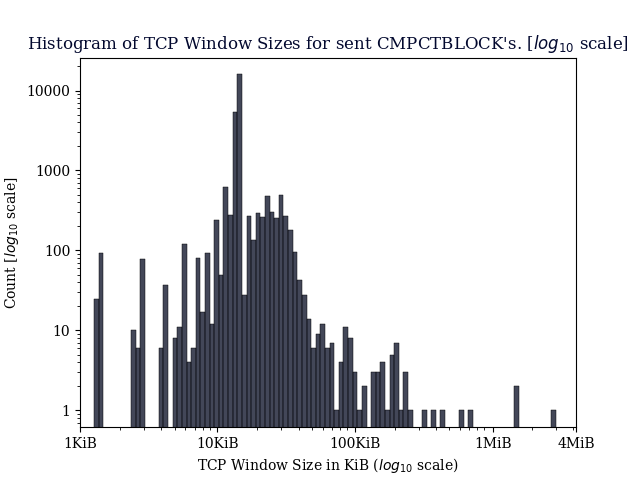

In [26]:
# Plot TCP Window Histogram
def plot_tcp_window_histogram(sent):
    histcolor = "#040920"

    f, ax1 = plt.subplots()
    # Histplot on top
    xticks_bytes = [1024, 10*1024, 100*1024, 1024*1024, 4*1024*1024] # 256B, 1KB, 10KB, 100KB, 1MB, 4MB
    xtick_labels = ['1KiB','10KiB', '100KiB', '1MiB', '4MiB']
    sns.histplot(data=sent, x='tcp_window_size', ax=ax1, color=histcolor, log_scale=10, bins=100)
    ax1.set_title(r"Histogram of TCP Window Sizes for sent CMPCTBLOCK's. [$log_{10}$ scale]", fontdict=font)
    ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax1.xaxis.set_label_text('TCP Window Size in KiB ($log_{10}$ scale)')
    ax1.set_xticks(xticks_bytes)
    ax1.set_xticklabels(xtick_labels)
    ax1.set_xlim([1024, 4*1024*1024])
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax1.yaxis.set_label_text('Count [$log_{10}$ scale]')

plot_tcp_window_histogram(prefiller_sent)


## Prefilling node: stats on CMPCTBLOCK's sent

In [33]:
# SENT CMPCTBLOCK stats
def sent_stats(sent: pd.DataFrame) -> None:
    avg_send_size = sent['send_size'].mean()
    print(f"The average CMPCTBLOCK we sent was {avg_send_size:.2f} bytes.")
    prefilled_sends = sent[sent['prefill_size'] > 0]
    print(f"The average prefilled CMPCTBLOCK we sent was {prefilled_sends['send_size'].mean():.2f} bytes.")
    not_prefilled_sends = sent[sent['prefill_size'] == 0]
    print(f"The average prefilled CMPCTBLOCK we sent was {not_prefilled_sends['send_size'].mean():.2f} bytes.")

    total_cb_sent = len(sent)

    avg_available_bytes_all = sent['window_bytes_available'].mean()

    prefilled_sends = sent[sent['prefill_size'] > 0]
    total_prefilled_cb_sent = len(prefilled_sends)
    prefill_needed_rate = total_prefilled_cb_sent / total_cb_sent
    print(f"{total_prefilled_cb_sent}/{total_cb_sent} blocks were sent with prefills. ({prefill_needed_rate * 100:.2f}%)")
    print(f"Avg available prefill bytes for all CMPCTBLOCK's we sent: {avg_available_bytes_all:.2f} bytes")

    # At this point, we return if this is not a prefilling node.
    if total_prefilled_cb_sent == 0:
        return

    avg_prefill_bytes = prefilled_sends['prefill_size'].mean()
    prefills_that_fit = (prefilled_sends['prefill_size'] <= prefilled_sends['window_bytes_available']).sum()
    prefill_fit_rate = prefills_that_fit / total_prefilled_cb_sent
    avg_available_bytes_for_needed = prefilled_sends['window_bytes_available'].mean()

    print(f"Avg available prefill bytes for prefilled CMPCTBLOCK's we sent: {avg_available_bytes_for_needed:.2f} bytes")
    print(f"Avg total prefill size for CMPCTBLOCK's we prefilled: {avg_prefill_bytes:.2f} bytes")

    print(f"{prefills_that_fit}/{total_prefilled_cb_sent} prefilled blocks sent fit in the available bytes. ({prefill_fit_rate * 100:.2f}%)")

sent_stats(prefiller_sent)

The average CMPCTBLOCK we sent was 65732.80 bytes.
The average prefilled CMPCTBLOCK we sent was 91614.48 bytes.
The average prefilled CMPCTBLOCK we sent was 14483.78 bytes.
17536/26392 blocks were sent with prefills. (66.44%)
Avg available prefill bytes for all CMPCTBLOCK's we sent: 8679.14 bytes
Avg available prefill bytes for prefilled CMPCTBLOCK's we sent: 8362.04 bytes
Avg total prefill size for CMPCTBLOCK's we prefilled: 74593.04 bytes
15042/17536 prefilled blocks sent fit in the available bytes. (85.78%)


The average prefill size is notably large, but this is a consequence of some outlier blocks.

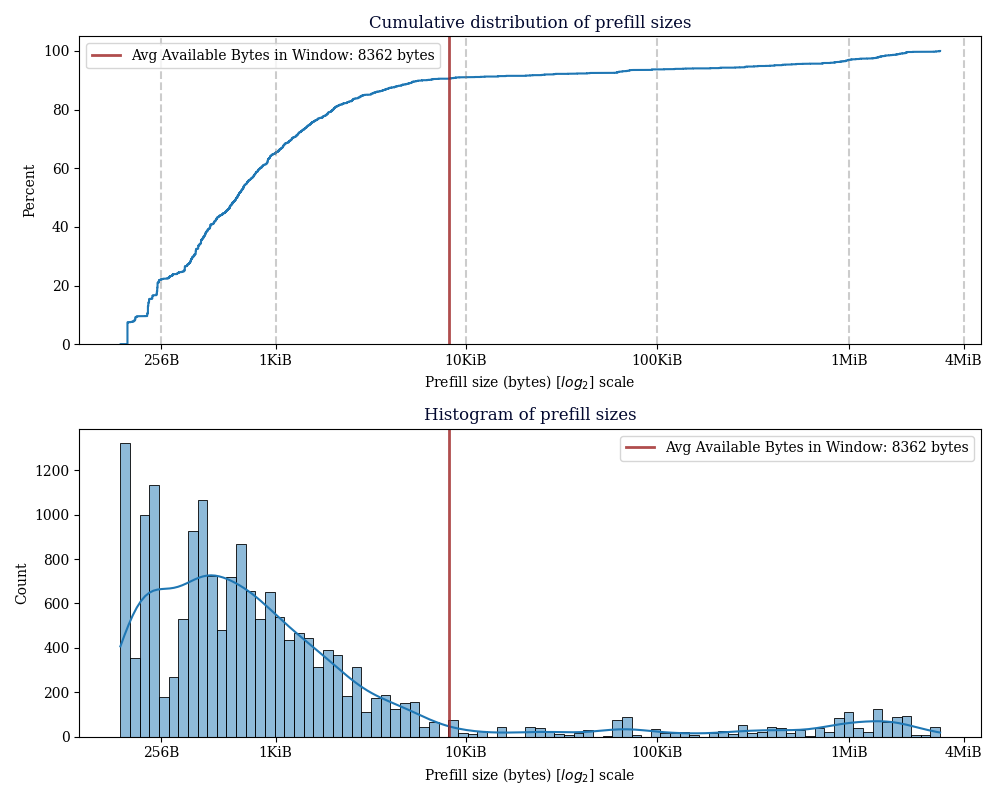

In [28]:
# Plot distribution of prefill sizes
def plot_prefill_distributions(sent):
    prefilled_sends = sent[sent['prefill_size'] > 0]

    xticks = [256, 1024, 10*1024, 100*1024, 1024*1024, 4*1024*1024]
    xtick_labels = ['256B', '1KiB', '10KiB', '100KiB', '1MiB', '4MiB']
    # Special red vertical line for the average available space for prefill
    avg_prefill_size = prefilled_sends['window_bytes_available'].mean()
    avg_prefill_line = {
        'x': avg_prefill_size,
        'color': '#9c2020',
        'alpha': 0.8,
        'linestyle': '-',
        'linewidth': 2,
        'label': f"Avg Available Bytes in Window: {avg_prefill_size:.0f} bytes",
    }

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8), tight_layout=True)
    sns.ecdfplot(data=prefilled_sends, x="prefill_size", log_scale=2, stat='percent', ax=ax1)
    ax1.set_title('Cumulative distribution of prefill sizes', fontdict=font)
    ax1.set_xticks(xticks)
    # Draw vertical lines at each tick
    for xtick in xticks:
        ax1.axvline(x=xtick, color='gray', linestyle='--', alpha=0.4)

    ax1.xaxis.set_label_text("Prefill size (bytes) [$log_{2}$] scale")
    ax1.set_xticklabels(xtick_labels)

    ax1.axvline(**avg_prefill_line)
    ax1.legend()

    sns.histplot(data=prefilled_sends, x="prefill_size", log_scale=2, ax=ax2, kde=True)
    ax2.set_title('Histogram of prefill sizes', fontdict=font)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xtick_labels)
    ax2.xaxis.set_label_text("Prefill size (bytes) [$log_{2}$] scale")

    ax2.axvline(**avg_prefill_line)
    ax2.legend()

plot_prefill_distributions(prefiller_sent)

### `vExtraTxnForCompact`
But, we can probably do even better, since the above statistics are for prefilling *with* all of the transactions in `vExtraTxnForCompactBlock`, and as I understand, it is very likely for peers running the same branch of Bitcoin Core to have a similar `vExtraTxnForCompactBlock`'s to one another. So it is likely that reconstruction will often succeed even without these transactions, so they should be the first candidates for not being included in the prefill. Unfortunately, their size is not something that Bitcoin Core logs, although I tried to compute it with a heuristic: `prefill_size - missing_txns_we_requested_size`, but it turned out this was very incorrect.

### Overflowing window before pre-fill.
Interestingly, some compact blocks were already so large *before* prefilling that they required more than one TCP round-trip to be sent, while this circumstance is not ideal, prefilling performs better by taking advantage of this.


In [14]:
def sent_already_over_stats(sent: pd.DataFrame) -> None:
    total_cb_sent = len(sent)

    excessive = sent[sent['rtts_without_prefill'] > 1]
    already_over_rtt_rate = len(excessive) / total_cb_sent if total_cb_sent > 0 else 0
    print(f"{len(excessive)}/{total_cb_sent} CMPCTBLOCK's sent were already over the window for a single RTT before prefilling. ({already_over_rtt_rate * 100:.2f}%)")

    avg_available_bytes_in_exceeded = excessive['window_bytes_available'].mean()
    print(f"Avg. available bytes for prefill in blocks that were already over a single RTT: {avg_available_bytes_in_exceeded:.2f} bytes")
    excessive_that_fit = excessive['prefill_size'] <= excessive['window_bytes_available']
    excessive_fit_rate = len(excessive_that_fit) / len(excessive)
    print(f"{len(excessive_that_fit)}/{len(excessive)} excessively large blocks had prefills that fit. ({excessive_fit_rate * 100:.2f}%)")

sent_already_over_stats(prefiller_sent)

1432/26392 CMPCTBLOCK's sent were already over the window for a single RTT before prefilling. (5.43%)
Avg. available bytes for prefill in blocks that were already over a single RTT: 8555.57 bytes
1432/1432 excessively large blocks had prefills that fit. (100.00%)
